In [ ]:
!pip install aif360

In [ ]:
pip install fairlearn

In [ ]:
# pip install --upgrade seaborn

In [ ]:
import os
os.chdir(r"/usr/local/lib/python3.10/dist-packages/aif360/data/raw/adult")
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

In [ ]:
# from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import log_loss, accuracy_score, f1_score, precision_score, recall_score, make_scorer, classification_report, confusion_matrix
import itertools
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import seaborn as sns
import pandas as pd
import aif360.sklearn.metrics as aim

pip install 'aif360[LawSchoolGPA]'


# Get data

In [ ]:
df = load_preproc_data_adult(['sex'])
privileged = [{'sex': 1}]
unprivileged = [{'sex': 0}]

In [ ]:
train, test = df.split([0.70], shuffle=True)
print("Train size", train.features.shape)
print("Test size", test.features.shape)
weights = np.array(train.instance_weights)

X_train = train.features
y_train = train.labels.ravel()

X_test = test.features
y_test = test.labels.ravel()

Train size (34189, 18)
Test size (14653, 18)


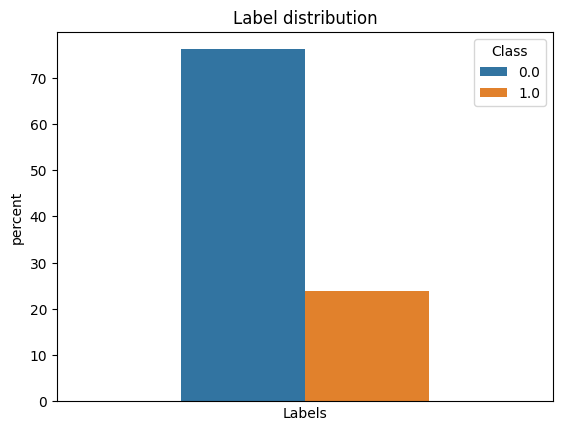

In [ ]:
label_df = pd.DataFrame({'Labels': [1]*len(y_train), 'Class': y_train})
sns.countplot(data=label_df, x='Labels', hue='Class', width=0.5, stat='percent')
plt.title('Label distribution')
plt.xticks([])
plt.show()

# Bias - variance

In [ ]:
def rf_results(params):
    model = LogisticRegression(
        solver=params[0],
        C=params[1]
    )

    model.fit(X_train, y_train)

    tn_p = model.predict_proba(X_train)
    ts_p = model.predict_proba(X_test)

    tn_pr = model.predict(X_train)
    ts_pr = model.predict(X_test)

    tn_l = log_loss(y_train, tn_p)
    ts_l = log_loss(y_test, ts_p)

    tn_f = f1_score(y_train, tn_pr, average='macro', zero_division=0)
    ts_f = f1_score(y_test, ts_pr, average='macro', zero_division=0)

    tn_a = accuracy_score(y_train, tn_pr)
    ts_a = accuracy_score(y_test, ts_pr)

    return (tn_l, ts_l), (tn_f, ts_f), (tn_a, ts_a)

In [ ]:
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
C = np.linspace(0.001, 0.05, 50)

all_combinations = list(itertools.product(solver, C))

log_losses = []
f_scores = []
accuracies = []


for i, combination in enumerate(all_combinations):
    ll, fsc, acc = rf_results(combination)

    log_losses.append(ll)
    f_scores.append(fsc)
    accuracies.append(acc)

    if i%20==0:
        print(f"{i+1}/{len(all_combinations)}")

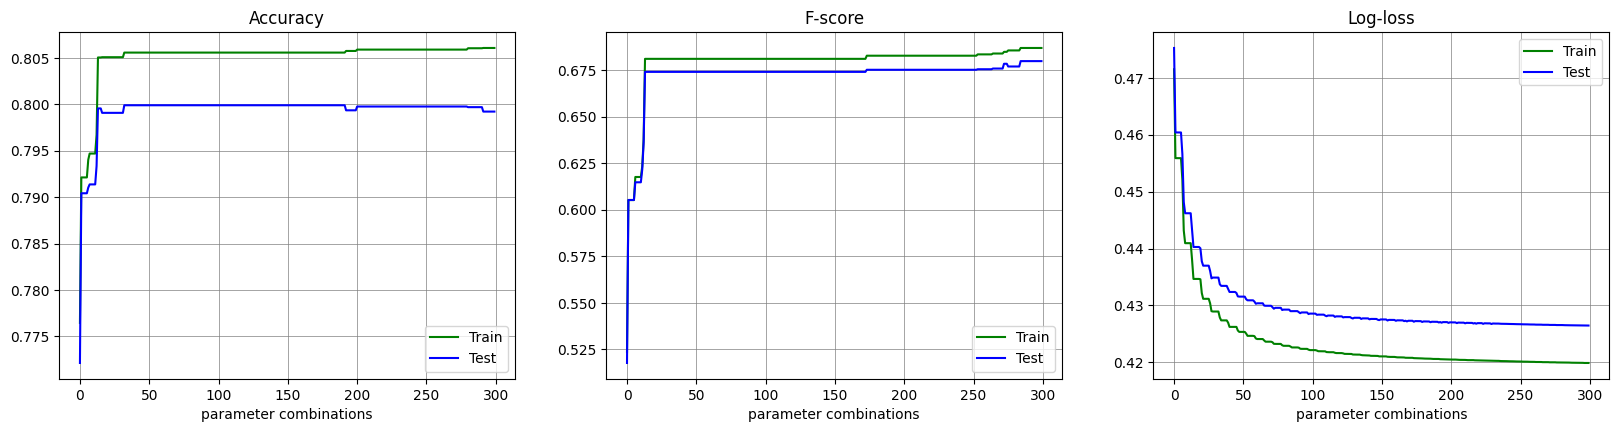

In [ ]:
sets = {'Accuracy': accuracies, 'F-score': f_scores, 'Log-loss': log_losses}

plt.figure(figsize=(20, 4.5))
for i, tset in enumerate(sets.items()):
    plt.subplot(1, 3, i+1)
    if i==2:
        souts = sorted(tset[1], key=lambda x: x[0], reverse=True)
    else:
        souts = sorted(tset[1], key=lambda x: x[0])

    tnouts, tsouts = zip(*souts)
    plt.plot(tnouts, color='green', label='Train')
    plt.plot(tsouts, color='blue', label='Test')
    plt.legend()
    plt.title(tset[0])
    plt.xlabel("parameter combinations")
    plt.grid(True, linewidth=0.5, color='gray')

plt.show()

# Classifiers

In [ ]:
def accurate_model(X_train, y_train, weights):

    n_estimators = [10, 20, 50]
    max_depth = np.arange(1, 12, 1)
    max_features = ['sqrt', 'log2', None]

    parameter_grid = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'max_features': max_features,
                    }

    estimator = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced')

    gs = GridSearchCV(estimator, param_grid=parameter_grid, scoring='neg_log_loss', cv=3, verbose=4)
    gs.fit(X_train, y_train, sample_weight=weights)


    return gs.best_estimator_

In [ ]:
def fair_model(X_train, y_train, weights):

    n_estimators = [10, 20, 50]
    max_depth = np.arange(1, 12, 1)
    max_features = ['sqrt', 'log2', None]

    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=9)
    prms = ['n_estimators', 'max_depth', 'max_features', 'n_jobs', 'random_state', 'class_weight']
    fairness_results = []
    for n in n_estimators:
        for d in max_depth:
            for f in max_features:
                fair_model = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f, n_jobs=-1, random_state=42, class_weight='balanced')
                cv = 1
                for train_index, test_index in kfold.split(X_train, y_train):
                    X, x = X_train[train_index], X_train[test_index]
                    Y, y = y_train[train_index], y_train[test_index]
                    wt = [weights[i] for i in train_index]
                    fair_model.fit(X, Y, sample_weight=wt)
                    parr = {k: v for k, v in fair_model.get_params().items() if k in prms}
                    yp = fair_model.predict(x)
                    di = aim.disparate_impact_ratio(pd.Series(y), yp, prot_attr=pd.Series([k[1] for k in x]), zero_division=0)
                    di = round(di, 3)

                    print(f"CV: {cv}", end="; ")
                    cv+=1
                    print(f"Params: {parr}", end="; ")
                    print(f"DI score: {di}")
                    fairness_results.append((parr, di))

    fairness_results = sorted(fairness_results, key=lambda x: x[1], reverse=True)
    fair_params = fairness_results[0][0]

    fairness = RandomForestClassifier(**fair_params)
    for train_index, test_index in kfold.split(X_train, y_train):
        X, x = X_train[train_index], X_train[test_index]
        Y, y = y_train[train_index], y_train[test_index]
        wt = [weights[i] for i in train_index]
        fairness.fit(X, Y, sample_weight=wt)

    return fairness

In [ ]:
def view_proportions(ground_truth, predictions):
    verdicts = []

    for a, b in zip(ground_truth, predictions):
        if a==1 and b==1:
            verdicts.append('True positive')
        if a==1 and b==0:
            verdicts.append('False negative')
        if a==0 and b==1:
            verdicts.append('False positive')
        if a==0 and b==0:
            verdicts.append('True negative')

    return verdicts

# Most accurate

In [ ]:
acc_uw_model = accurate_model(X_train, y_train, weights)

In [ ]:
acc_pred_y = acc_uw_model.predict(X_test)
print(classification_report(y_test, acc_pred_y))

              precision    recall  f1-score   support

         0.0       0.91      0.70      0.80     11132
         1.0       0.46      0.79      0.58      3521

    accuracy                           0.73     14653
   macro avg       0.69      0.75      0.69     14653
weighted avg       0.81      0.73      0.74     14653



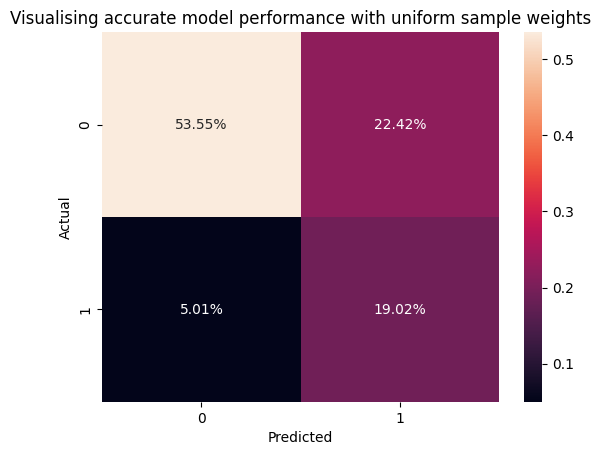

In [ ]:
conf_matrix = confusion_matrix(y_test, acc_pred_y)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Visualising accurate model performance with uniform sample weights")
plt.show()

In [ ]:
test_pred_acc = test.copy()
test_pred_acc.labels = acc_pred_y
f_metric = ClassificationMetric(test, test_pred_acc, unprivileged_groups=unprivileged, privileged_groups=privileged)

print("Fairness metrics of accurate model on unweighted samples:-")
print("Equal opportunity difference: ", round(f_metric.equal_opportunity_difference(), 4))
print("Disparate Impact: ", round(f_metric.disparate_impact(), 4))

Fairness metrics of accurate model on unweighted samples:-
Equal opportunity difference:  -0.3934
Disparate Impact:  0.2722


# Most fair

In [ ]:
far_uw_model = fair_model(X_train, y_train, weights)

In [ ]:
fpred = far_uw_model.predict(X_test)
print(classification_report(y_test, fpred))

              precision    recall  f1-score   support

         0.0       0.84      0.83      0.83     11132
         1.0       0.48      0.51      0.50      3521

    accuracy                           0.75     14653
   macro avg       0.66      0.67      0.66     14653
weighted avg       0.76      0.75      0.75     14653



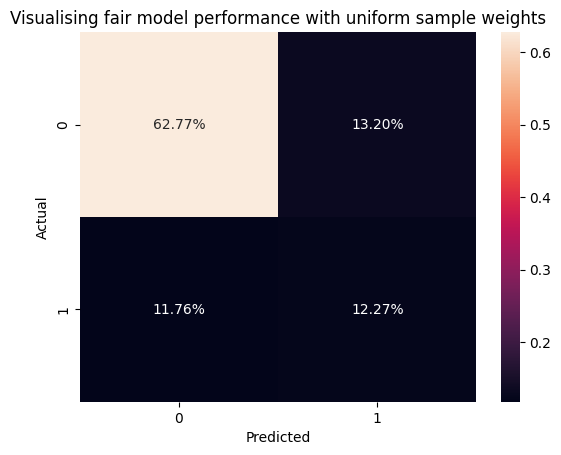

In [ ]:
conf_matrix = confusion_matrix(y_test, fpred)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Visualising fair model performance with uniform sample weights")
plt.show()

In [ ]:
test_pred_fair = test.copy()
test_pred_fair.labels = fpred
f_metric = ClassificationMetric(test, test_pred_fair, unprivileged_groups=unprivileged, privileged_groups=privileged)

print("Fairness metrics of fair model on unweighted samples:-")
print("Equal opportunity difference: ", round(f_metric.equal_opportunity_difference(), 4))
print("Disparate Impact: ", round(f_metric.disparate_impact(), 4))

Fairness metrics of fair model on unweighted samples:-
Equal opportunity difference:  0.0155
Disparate Impact:  0.8343


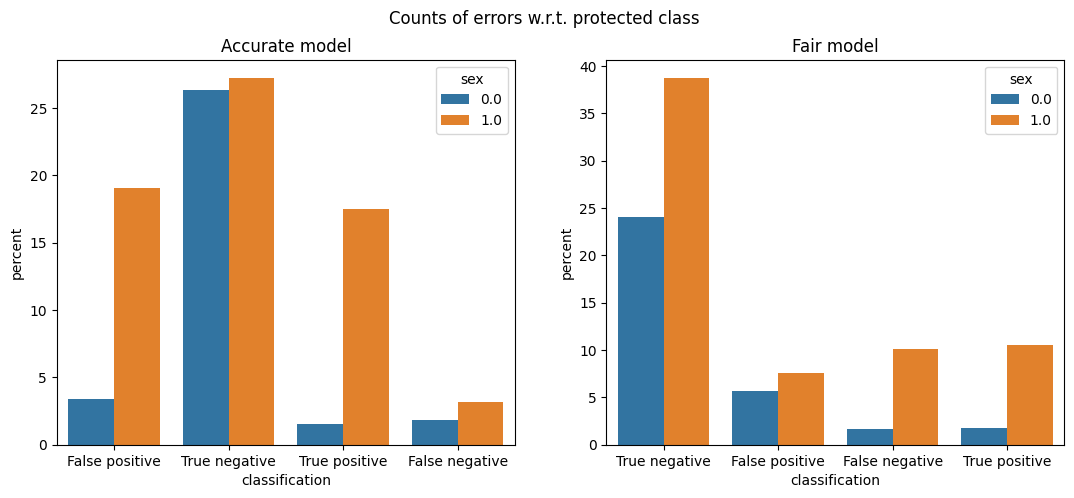

In [ ]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
acc_verd = view_proportions(y_test, acc_pred_y)
fdf = pd.DataFrame({'sex': [k[1] for k in X_test], 'classification': acc_verd})
sns.countplot(data=fdf, x='classification', hue='sex', stat='percent')
plt.title("Accurate model")

plt.subplot(1, 2, 2)
fair_verd = view_proportions(y_test, fpred)
fdf = pd.DataFrame({'sex': [k[1] for k in X_test], 'classification': fair_verd})
sns.countplot(data=fdf, x='classification', hue='sex', stat='percent')
plt.title("Fair model")


plt.suptitle("Counts of errors w.r.t. protected class")
plt.show()

# Reweighing

In [ ]:
rw = Reweighing(unprivileged_groups=unprivileged, privileged_groups=privileged)

train_rw = rw.fit_transform(train)

X_train = train_rw.features
y_train = train_rw.labels.ravel()
weights = np.array(train_rw.instance_weights)

In [ ]:
acc_rw_model = accurate_model(X_train, y_train, weights)

In [ ]:
acc_pred_y = acc_rw_model.predict(X_test)
print(classification_report(y_test, acc_pred_y))

              precision    recall  f1-score   support

         0.0       0.89      0.71      0.79     11132
         1.0       0.44      0.72      0.55      3521

    accuracy                           0.71     14653
   macro avg       0.67      0.72      0.67     14653
weighted avg       0.78      0.71      0.73     14653



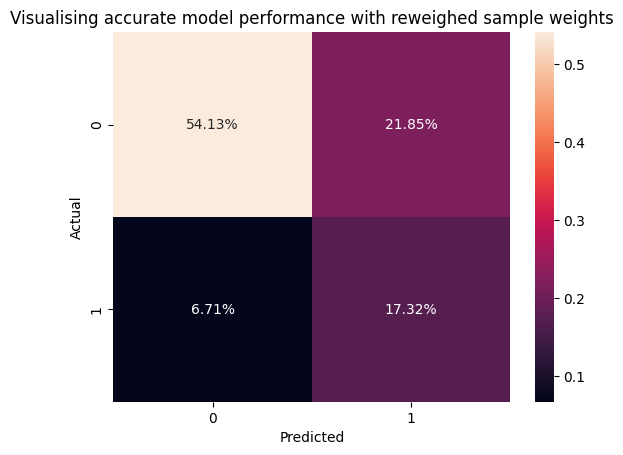

In [ ]:
conf_matrix = confusion_matrix(y_test, acc_pred_y)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Visualising accurate model performance with reweighed sample weights")
plt.show()

In [ ]:
test_pred_acc = test.copy()
test_pred_acc.labels = acc_pred_y
f_metric = ClassificationMetric(test, test_pred_acc, unprivileged_groups=unprivileged, privileged_groups=privileged)

print("Fairness metrics of accurate model on reweighed samples:-")
print("Equal opportunity difference: ", round(f_metric.equal_opportunity_difference(), 4))
print("Disparate Impact: ", round(f_metric.disparate_impact(), 4))

Fairness metrics of accurate model on reweighed samples:-
Equal opportunity difference:  0.0329
Disparate Impact:  0.9351


In [ ]:
far_rw_model = fair_model(X_train, y_train, weights)

In [ ]:
fpred = far_rw_model.predict(X_test)
print(classification_report(y_test, fpred))

              precision    recall  f1-score   support

         0.0       0.89      0.72      0.79     11132
         1.0       0.44      0.71      0.55      3521

    accuracy                           0.72     14653
   macro avg       0.67      0.71      0.67     14653
weighted avg       0.78      0.72      0.73     14653



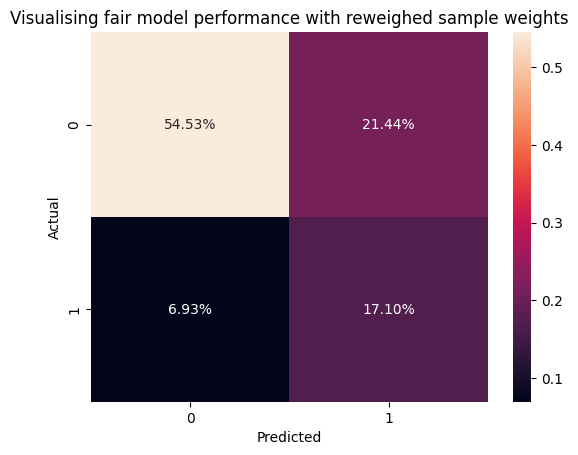

In [ ]:
conf_matrix = confusion_matrix(y_test, fpred)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Visualising fair model performance with reweighed sample weights")
plt.show()

In [ ]:
test_pred_fair = test.copy()
test_pred_fair.labels = fpred
f_metric = ClassificationMetric(test, test_pred_fair, unprivileged_groups=unprivileged, privileged_groups=privileged)

print("Fairness metrics of fair model on reweighed samples:-")
print("Equal opportunity difference: ", round(f_metric.equal_opportunity_difference(), 4))
print("Disparate Impact: ", round(f_metric.disparate_impact(), 4))

Fairness metrics of fair model on reweighed samples:-
Equal opportunity difference:  0.0461
Disparate Impact:  0.961


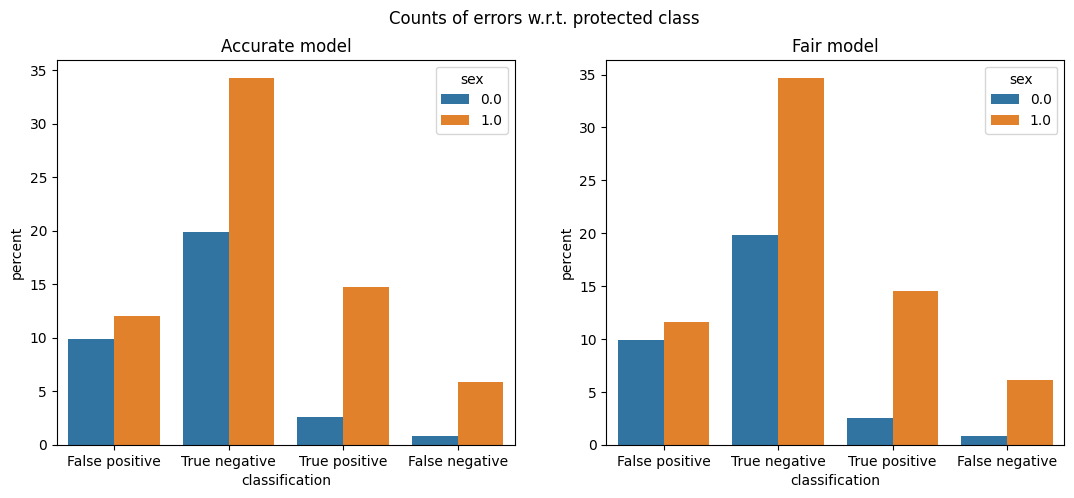

In [ ]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
acc_verd = view_proportions(y_test, acc_pred_y)
fdf = pd.DataFrame({'sex': [k[1] for k in X_test], 'classification': acc_verd})
sns.countplot(data=fdf, x='classification', hue='sex', stat='percent')
plt.title("Accurate model")

plt.subplot(1, 2, 2)
fair_verd = view_proportions(y_test, fpred)
fdf = pd.DataFrame({'sex': [k[1] for k in X_test], 'classification': fair_verd})
sns.countplot(data=fdf, x='classification', hue='sex', stat='percent')
plt.title("Fair model")


plt.suptitle("Counts of errors w.r.t. protected class")
plt.show()